## Download, slice, concatenate and store data from the National Snow and Ice Data Center ##
This recipe demonstrates how you can prepare a nicely formatted yearly organised set of properly formatted NetCDF files from the NSIDC database "Measures". The recipe is tested on AMSR-E data (6.25Km) and set up to allow for variations in frequency, Ascending/Descending orbits and Horizontal / Vertical polarization. These settings are used to construct download urls which are then retrieved using wget behind the scenes. If you are using windows, please retrieve a wget .exe for your system from https://eternallybored.org/misc/wget/

Information about datasets that may also be retrieved (but may require different settings and projection information) can be found on the NSIDC pages for each product for instance http://nsidc.org/data/nsidc-0630

To make the recipe work for tour product of interest, a reconstruction of a proper url template is needed. Have a look in the code below to adapt that.

In [7]:
%reload_ext autoreload
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np

# import our own small lib
import nsidc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
os.path.abspath('/')

'C:\\'

First, construct a bunch of settings for your specific data of interest. The idea is to construct urls in a loop by filling in a template, and retrieve these urls. Then read them, manipulate them and store them separately. 
- supply your own nasa earthdata username and password. 
- fill in the required bits and pieces to retrieve the right data for your case (Change template accordingly)
In the case below, we vary the url string accoding to frequency, polarization, orbit and time span. This may be different for your use case.

In [9]:
url_base = 'https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/'
#import pdb; pdb.set_trace()
url_folder = '{:s}/'
url_template = url_base + url_folder + 'NSIDC-0630-EASE2_T{:s}km-AQUA_AMSRE-{:s}-{:s}{:s}-{:s}-{:s}-v1.3.nc'
download_template = 'wget --http-user={:s} --http-password={:s} --load-cookies mycookies.txt --save-cookies mycookies.txt --keep-session-cookies --no-check-certificate --auth-no-challenge -r --reject "index.html*" -np -e robots=off {:s}'

fn_out_template = 'NSIDC-0630-EASE2_T{:s}km-AQUA-AMSRE-{:s}{:s}-{:s}_{:04d}.nc'
out_path = os.path.abspath('netcdf')
if not(os.path.isdir(out_path)):
    # prepare the output path
    os.makedirs(out_path)
freq = '37' # 36 GhZ following Brakenridge 2007 (WRR M/C ratio paper)
res = '25'  # can also be 12.5 or 25, although this depends on the chosen frequency as well
# freq = '36' # 36 GhZ following Brakenridge 2007 (WRR M/C ratio paper)
HV = 'V' # Horizontal or Vertical polarisation
AD = 'A' # Ascending or descending, descending contains imagery during the day, probably showing more contrast

# start_date = datetime.datetime(2002, 6, 1)
start_date = datetime.datetime(2010, 1, 1) # date after data recovery
#end_date = datetime.datetime(2002, 6, 5)  # only a few days to make a demonstration
end_date = datetime.datetime(2011, 12, 31)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2005, 1, 1)
step = datetime.timedelta(days=1)  # M

try:
    credential_fn = os.path.abspath('../../nsidc_credentials.txt')
    username, password = str(np.loadtxt(credential_fn, dtype=np.str)).split(',')
except:
    print('No credential file found, please put a txt file with <user>,<pass> in {:s}'.format(credential_fn))
 

In [10]:
print(url_folder)

{:s}/


In [11]:
print(' Frequency:',freq,'GHz.', 
      ' Resolution:',res, 'km.',
      ' Polarization:', HV,'.' 
      ' Ascending/descending:', AD)

 Frequency: 37 GHz.  Resolution: 25 km.  Polarization: V . Ascending/descending: A


We also need some information on geographical coverage. What bounding box would you like to retrieve? We need a projection method from latlon to the projection of the dataset itself to accomodate a proper geographical slicing. In the nsidc.py lib, a number of projection routines is provided to accomodate moving from one projection to the other. 

In [10]:
# define the proj4string belonging to the grids you are downloading. You can find these in a downloaded sample 
# under the variable/attribute crs.proj4text. Here we simply copy-paste that.
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
points_interest = [(2.4406387000000223, 6.893251099999999),
                   (2.2999999999999545, 7.099999999999999),
                   (2.4851462999999967, 8.0335995),
                   (2.0499999999999545, 7.566667)
]

# In this example, we are interested in parts of West-Africa, so we provide a bounding box covering that in the format
# [(xmin, ymin), (xmax, ymax)]
bounds = [(-5., 0.),
          (10., 15.),
         ]

# bounds = [(20., -20.),
#           (40., -8.),
#          ]  # alternative bounds around Zambezi river basin


# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)

# now we're all set!

We have all information we need. Now we just need a nice loop with some intelligence when to write a file. We write it on annual basis. You can adapt this of course. Some important things:
- we need to be able to track the location of the download and construct a proper file name. We do this by stripping parts of the url.
- after retrieval and massaging, we need to throw away the downloaded stuff. We also strip the folder structure so that we can delete this after we're done with a file.
- the files are apparently not entirely CF-compliant. There is a conflicting missing_value and _FillValue number. In our example, the _FillValue represented the right missing, so we simply overwrite the missing_value attribute by the _FillValue attribute in a small function correct_miss_fill. We return a cf decoded dataset from that function. This is nice because it interprets dates and times very nicely.
- this part takes a long time if you decide to download a large dataset!! So please first test it on only a small part of the world or a few time slices.

In [11]:
import time
dt = start_date
list_ds = []
year = dt.year # let's store data per year

while dt <= end_date:
    url = nsidc.make_measures_url(url_template, res, dt, freq, HV, AD)  # make the url string to download
    fn = url.strip('https://')  # strip https:// from the url to get the local location of the downloaded file
    path = fn.split('/')[0]  # split fn in little pieces on / and keep only the 0-th indexed piece (main folder)
    download = nsidc.make_measures_download(download_template, url, username, password)  # pass the url to a download string template
    success = subprocess.call(download)  # call the download string in a command-line (use wget.exe! get it from online)
    if success == 0:
        print('Retrieved {:s}'.format(url))
        # the file was successfully downloaded (if not zero, there was a problem or file is sinmply not available)
        # read file, cut a piece and add it to our list of time steps
        ds = xr.open_dataset(fn, decode_cf=False)
        ds_sel = nsidc.select_bounds(ds, bounds_xy)
        list_ds.append(ds_sel.load())  # load the actual data so that we can delete the original downloaded files
        ds.close()
        #time.sleep(0.001)
        shutil.rmtree(path)  # we're done cutting part of the required grid, so throw away the originally downloaded world grid.
    dt += step   # increase by one day to go for the next download day.
    if (year != dt.year) or (dt > end_date):  # store results if one moves to a new year or the end date is reached
        # concatenate the list of timesteps into a new ds
        if len(list_ds) > 0:
            # only store if any values were found
            ds_year = nsidc.correct_miss_fill(xr.concat(list_ds, dim='time'))
            # ds_year.data_vars
            encoding = {var: {'zlib': True} for var in ds_year.data_vars if var != 'crs'}
            # store the current dataset into a nice netcdf file
            fn_out = os.path.abspath(os.path.join(out_path, fn_out_template.format(str(res), freq, HV, AD, year)))
            print('Writing output for year {:d} to {:s}'.format(year, fn_out))
            ds_year.to_netcdf(fn_out, encoding=encoding)
        # prepare a new dataset
        list_ds = []  # empty list
        year = dt.year  # update the year


Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.01.01/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010001-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.01.02/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010002-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.01.03/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010003-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.01.04/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010004-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.01.05/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010005-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.01.06/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010006-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.01.07/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010007-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.02.28/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010059-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.03.01/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010060-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.03.02/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010061-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.03.03/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010062-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.03.04/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010063-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.03.05/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010064-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.03.06/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010065-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.04.27/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010117-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.04.28/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010118-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.04.29/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010119-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.04.30/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010120-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.05.01/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010121-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.05.02/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010122-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.05.03/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010123-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.06.24/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010175-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.06.25/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010176-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.06.26/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010177-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.06.27/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010178-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.06.28/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010179-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.06.29/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010180-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.06.30/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010181-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.08.21/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010233-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.08.22/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010234-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.08.23/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010235-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.08.24/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010236-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.08.25/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010237-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.08.26/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010238-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.08.27/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010239-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.10.18/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010291-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.10.19/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010292-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.10.20/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010293-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.10.21/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010294-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.10.22/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010295-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.10.23/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010296-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.10.24/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010297-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.12.15/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010349-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.12.16/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010350-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.12.17/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010351-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.12.18/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010352-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.12.19/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010353-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.12.20/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010354-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2010.12.21/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2010355-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.02.10/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011041-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.02.11/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011042-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.02.12/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011043-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.02.13/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011044-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.02.14/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011045-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.02.15/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011046-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.02.16/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011047-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.04.09/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011099-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.04.10/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011100-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.04.11/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011101-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.04.12/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011102-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.04.13/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011103-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.04.14/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011104-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.04.15/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011105-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.06.06/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011157-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.06.07/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011158-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.06.08/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011159-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.06.09/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011160-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.06.10/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011161-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.06.11/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011162-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.06.12/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011163-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.08.03/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011215-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.08.04/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011216-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.08.05/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011217-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.08.06/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011218-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.08.07/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011219-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.08.08/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011220-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.08.09/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011221-89V-D-SIR-RSS-v1.3.nc

Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.09.30/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011273-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.10.01/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011274-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.10.02/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011275-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.10.03/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011276-89V-D-SIR-RSS-v1.3.nc
Retrieved https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0630.001/2011.10.04/NSIDC-0630-EASE2_T3.125km-AQUA_AMSRE-2011277-89V-D-SIR-RSS-v1.3.nc
Writing output for year 2011 to C:\Users\908138\githubmain\NSIDC-AMSRE\netcdf\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89V-D_2011.nc


Ok, we should have some data now. Let's see if we can make a plot over a geographical map to demonstrate. We plot the first time step of brightness temperature in the last saved file below.

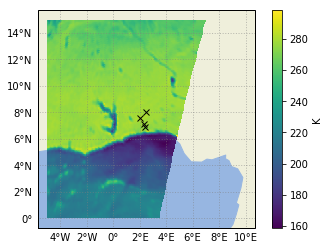

In [8]:
ds = xr.open_dataset(fn_out)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
# get a mesh of the coordinates in grid's projection
xi, yi = np.meshgrid(ds.x, ds.y)

# the chosen projection is not (yet) supported by caropy.crs, so we need to do the transformation ourselves for now. 
# No biggy, here we go
loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)

# now drape the data on the map
p = ax.pcolormesh(loni, lati, ds['TB'][1].values, transform=ccrs.PlateCarree())

# also plot some points of interest 
ax = nsidc.plot_points(ax, points_interest, marker='x', color='k', linewidth=0., transform=ccrs.PlateCarree())
plt.colorbar(p, label='K')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Gracefully close ds
ds.close()

Looks good, now we can start playing with the data in follow-up notebooks.

In [26]:
proj_in